## Forecasting forex using ARIMA for USD/VND 
#### Using data from past two years (2021 and 2022), we'll forecast data for 2023 to forecast for next 12 months (short time period)
The purpose of this research is to forecast usd/vnd exchnage rate to use in our investment analysis.

# Import packages

In [337]:
# Import packages
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import DataFrame
from matplotlib import pyplot

from pmdarima.arima import auto_arima

## Input data

[*********************100%%**********************]  1 of 1 completed


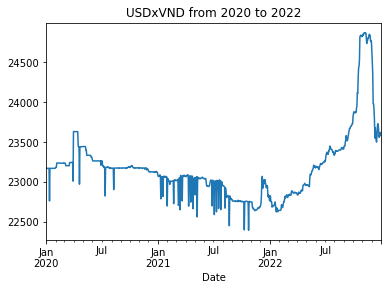

In [341]:
# Get data
data = yf.download('USDVND=X','2020-01-01','2022-12-31') # from 1 Jan 2021 to 31 December 2022

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2020 to 2022")
plt.show()

## Stationary test

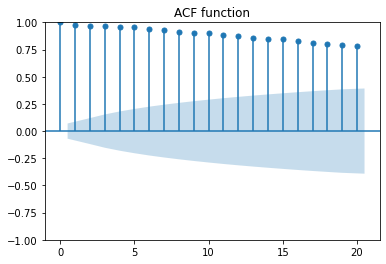

In [269]:
# Autocorrelation function (ACF) of data
plot_acf(data['Adj Close'], lags=20)
plt.title("ACF function")
plt.show()

If data is stationary, the ACF values is likely to drop off quickly

In [323]:
adftest = adfuller(data['Adj Close'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.3805069827608216
P-Value: 0.3900320349993804
Number of lags: 17
Number of observations: 765
Critical Values: {'1%': -3.9706529934914143, '5%': -3.4162446265323902, '10%': -3.130436626092361}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


**P-value is=above 0.05, therefore the value is not stationary**

##### Differencing 

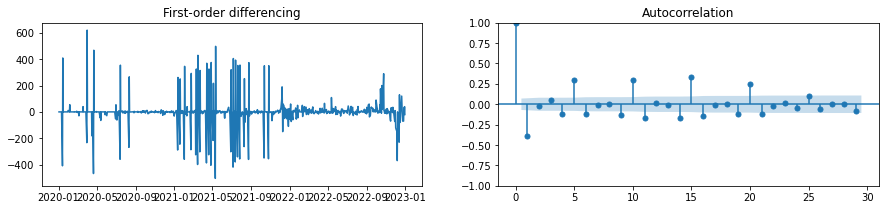

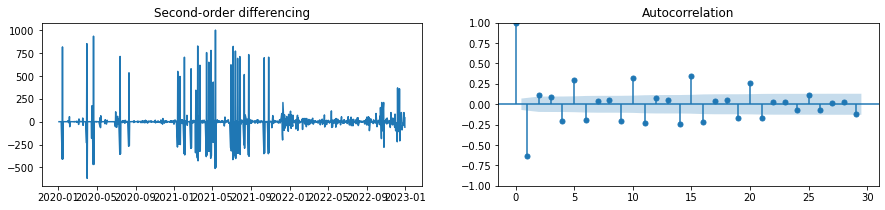

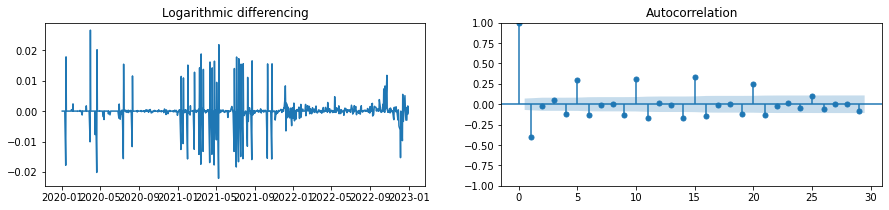

In [324]:
# First-order differencing
data['diff1'] = data['Adj Close'].diff()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('First-order differencing')
ax1.plot(data['diff1'])

data['growth_1'] = data['diff1']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['diff1'].dropna(), ax=ax2)
plt.show()

# Second order differencing
data['diff2'] = data['Adj Close'].diff().diff()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Second-order differencing')
ax1.plot(data['diff2'])

data['growth_2'] = data['diff2']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['diff2'].dropna(), ax=ax2)
plt.show()

# Log differencing
data['difflog'] = np.log(data['Adj Close']).diff()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Logarithmic differencing')
ax1.plot(data['difflog'])

data['growth_log'] = data['difflog']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['difflog'].dropna(), ax=ax2)
plt.show()


# ARIMA model parameters

##### Determining 'd'
NB: <br> - If data point of each lag are positive for several consecutive lags, more differencing required <br> - If more data points are negative, series is over-differenced <br> <br> **After first-order differencing, p-value drops beyond the acceptable threshold. Use 'd'= 1**

In [325]:
# Test stationarity with ADF
adftest = adfuller(data['growth_1'].dropna(), autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")


ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -6.176127852411916
P-Value: 3.943268215368074e-09
Number of lags: 15
Number of observations: 766
Critical Values {'1%': -2.568664980400712, '5%': -1.941356318195133, '10%': -1.6164778327068294}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


##### Determining 'p'

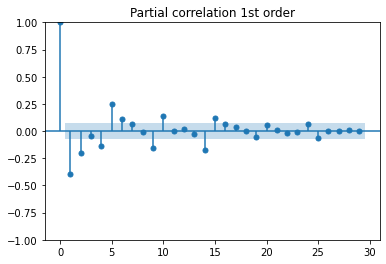

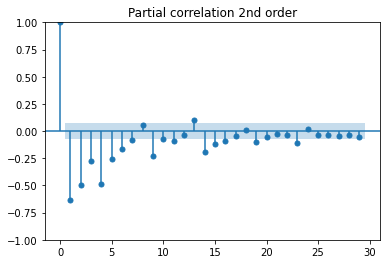

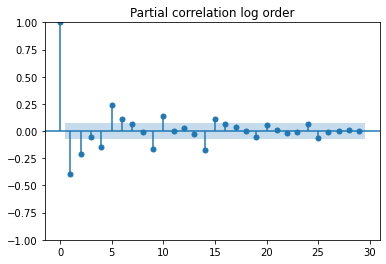

In [326]:
# Partial autocorrelation
plot_pacf(data['diff1'].dropna(),method='ywm')
plt.title('Partial correlation 1st order')
plt.show()

plot_pacf(data['diff2'].dropna(),method='ywm')
plt.title('Partial correlation 2nd order')
plt.show()

plot_pacf(data['difflog'].dropna(),method='ywm')
plt.title('Partial correlation log order')
plt.show()



In both all plots, the 1st lag is most significant, thus we consider 'p' to be 1 

##### Estimating 'q'

From ACF plot, determine number of lags crossing the threshold to determine how much of the past would be significant enough to consider for the future -- high correlation contribute more and would be enough to predict future values <br> From the plots above, set 'q' to 6

In [327]:
# Finding ARIMA parameters automatically
model = auto_arima(data['Adj Close'], seasonal=False, m = 1, suppress_warnings=True)
print(model.order)

(2, 1, 3)


# Fitting ARIMA

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  783
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -4599.189
Date:                Tue, 26 Mar 2024   AIC                           9210.378
Time:                        14:56:25   BIC                           9238.349
Sample:                    01-01-2020   HQIC                          9221.135
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0110      0.143     -0.077      0.938      -0.292       0.270
ar.L2          0.4355      0.135      3.222      0.001       0.171       0.700
ma.L1         -0.4925      0.144     -3.430      0.0

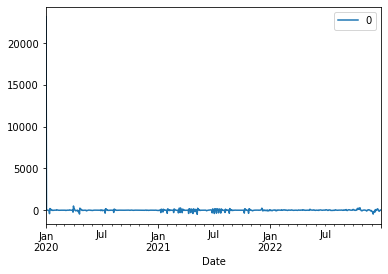

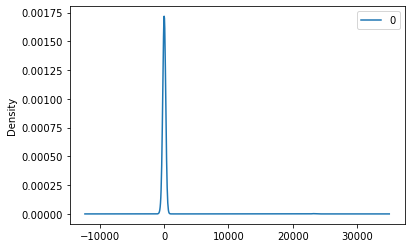

                  0
count    783.000000
mean      30.398038
std      832.559804
min     -492.234570
25%      -10.615516
50%        0.798948
75%       16.701762
max    23171.000000


In [328]:
arima_model = ARIMA(data['Adj Close'], order=(2,1,3)) # define model
model= arima_model.fit() # train model
print(model.summary()) 

# Line plot of residuals
residuals = DataFrame(model.resid)
residuals.plot()
pyplot.show()

# Density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

print(residuals.describe())

As MA parameter was put at 6, we have 6 trained coefficienct for MA and one for AR. We can see scores such as AIC, BIC, and HQIC, as well as the std dev of innovations (difference of real value at time t and predicted value at the time). <br> <br> AIC can be used to test goodness of fit and shpuld be as low as possible as it measures the amount of information lost by training and generalising the model. <br> <br> There is a non-zero mean in the residuals indicating a bias in the prediction.

# Forecast 

In [335]:
predictions = model.predict(len(data), len(data)+60)

actual = yf.download('USDVND=X', '2022-12-31','2023-03-31') 

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y = data['Adj Close'], mode = 'lines', name = 'Training Data', line = dict(color='blue'))) # training data line plot
fig.add_trace(go.Scatter(x=predictions.index, y = predictions, mode ='lines', name = 'Predictions', line = dict(color='red'))) # predictions line plot
fig.add_trace(go.Scatter(x=actual.index, y = actual['Adj Close'], mode = 'lines', name = 'Actual', line = dict(color='green')))

fig.update_layout(title="USDVND rates", xaxis_title = 'Date', yaxis_title = 'Adj Close',)

pio.show(fig)

[*********************100%%**********************]  1 of 1 completed


In [331]:
actual

""
